In [1]:
%%bash
pip install --upgrade pip
pip install sklearn

  Found existing installation: pip 8.1.2
    Uninstalling pip-8.1.2:
      Successfully uninstalled pip-8.1.2
  Running setup.py bdist_wheel for sklearn: started
  Running setup.py bdist_wheel for sklearn: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/d7/db/a3/1b8041ab0be63b5c96c503df8e757cf205c2848cf9ef55f85e
Successfully built sklearn


/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:318: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:122: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/pyth

In [3]:
%%bash
pip install --upgrade pandas
pip install --upgrade ipython

Requirement already up-to-date: pandas in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: pytz>=2011k in /usr/local/lib/python2.7/dist-packages (from pandas)
Requirement already up-to-date: python-dateutil in /usr/local/lib/python2.7/dist-packages (from pandas)
Requirement already up-to-date: numpy>=1.7.0 in /usr/local/lib/python2.7/dist-packages (from pandas)
Requirement already up-to-date: six>=1.5 in /usr/local/lib/python2.7/dist-packages (from python-dateutil->pandas)
Requirement already up-to-date: ipython in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: prompt-toolkit<2.0.0,>=1.0.4 in /usr/local/lib/python2.7/dist-packages (from ipython)
Requirement already up-to-date: decorator in /usr/local/lib/python2.7/dist-packages (from ipython)
Requirement already up-to-date: setuptools>=18.5 in /usr/local/lib/python2.7/dist-packages (from ipython)
Requirement already up-to-date: pickleshare in /usr/local/lib/python2.7/dist-packages (from ipy

In [3]:
import charts
import inspect
import numpy as np
import os
import pandas as pd
import pylab as pl
import sys
import time
import math
import matplotlib.pyplot as plt

from opengrid.library import houseprint
from scipy.signal import argrelextrema, butter, lfilter, freqz
from scipy import spatial
from scipy.spatial import distance
from scipy.stats import norm
from sklearn.cluster import MeanShift

from matplotlib.patches import Rectangle
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

Server running in the folder /usr/local/opengrid/notebooks/Analysis/Thesis_Max&Jean at 127.0.0.1:51903


ImportError: No module named sklearn.cluster

In [ ]:
pd.__version__

In [ ]:
hp = houseprint.Houseprint()
#hp.sync_tmpos()

# Functions for blockdetection

In [ ]:
def znormalization(ts):
    """
        This function ensures, that all elements are transformed into an output whose mean is approximately 0
        while the standard deviation is in a range close to 1.
    
        PARAMETERS
        ----------
            ts: pandas dataframe
            
        RETURNS
        -------
            pandas dataframe
    """
    
    mus = ts.mean(axis = 0)
    stds = ts.std(axis = 0)
    
    return (ts - mus) / stds

In [ ]:
def paa_transform(ts, n_pieces):
    """
        In order to reduce the dimensionality from n to M, we first divide the original time-series into M equally
        sized frames and secondly compute the mean values for each frame. The sequence assembled from the mean
        values is the PAA approximation (i.e., transform) of the original time-series.
        As it was shown by Keogh et al, the complexity of the PAA transform can be reduced from O(NM) to O(Mm) 
        where m is the number of frames.
        
        PARAMETERS
        ----------
            ts: numpy array
            n_pieces: int
            
        RETURNS
        -------
            numpy array
    """
    
    splitted = np.array_split(ts, n_pieces) ## along columns as we want
    
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [ ]:
def sax_transform(ts, n_pieces, alphabet="abcdefghijklmnop"):
    """
        In short, Symbolic Aggregate approXimation (SAX) algorithm application to the input time series transforms its into a strings.
    
        PARAMETERS
        ----------
            ts: numpy array
            n_pieces: int
            alphabet: string
            
        RETURNS
        -------
            numpy array
    """
    
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    
    return np.apply_along_axis(translate, 0, paa_ts)

In [4]:
def makeArray(array1):
    """
        turns string into array
    
        PARAMETERS
        ----------
            array1: pandas Dataframe
            
        RETURNS
        -------
            pandas Dataframe
    """
    
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [5]:
def find_blocks(df_parent, row_parent, blocks, df_original, first_time = True):
    """
        This function loops through the data and detects all possible events
    
        PARAMETERS
        ----------
            df_parent: pandas Dataframe
            row_parent: int
            blocks: pandas Dataframe
            df_original: pandas Dataframe
            first_time: Boolean
            
        RETURNS
        -------
            pandas Dataframe
    """
    
    min_lvl = 0
    start = False
    
    block_start = 0
    block_end = 0
    
    nr_of_blocks_start = blocks.size
    
    nested = row_parent
    
    if first_time:
        start = True
        min_lvl = df_parent['repeatedValues'].min()
        
    #append last value again
    post_index = df_parent.index[-1] + pd.Timedelta(minutes=1)

    temp = pd.DataFrame(data=[df_parent.iloc[-1]], index=[post_index], columns=['repeatedValues'])
    df_parent = df_parent.append(temp)

    df_parent.sort_index(inplace=True)

    for i in range(1, df_parent.size - 1):
        if start == False and df_parent['repeatedValues'].iloc[i - 1] - df_parent['repeatedValues'].iloc[i] == 0:
            min_lvl = df_parent['repeatedValues'].iloc[i]
            start = True
        
        if start == True and df_parent['repeatedValues'].iloc[i] > min_lvl and df_parent['repeatedValues'].iloc[i - 1] == min_lvl:
            block_start = df_parent.index[i - 1]
            
        if start == True and block_start != 0 and df_parent['repeatedValues'].iloc[i] <= min_lvl:
            block_end = df_parent.index[i]
            
            #Match if the length is more than 10% less than the parent
            temp = pd.DataFrame(data=[[str(block_start), str(block_end), nested]], columns=['start', 'stop', 'nested_in'])
            
            if float(df_parent.index.size - df_parent.ix[block_start : block_end].index.size) / float(df_parent.index.size) > 0.25:
                blocks = blocks.append(temp, ignore_index=True)
            
            df_parent2 = df_original.ix[block_start : block_end]
            row_parent = blocks.index.size - 1
            blocks = find_blocks(df_parent2, row_parent, blocks, df_original, False)
            
            block_start = 0
            block_end = 0
            
        if start == True and block_start == 0 and df_parent['repeatedValues'].iloc[i] < min_lvl:
            #Lvl dropped below min value so the min value was not assigned properly
            if df_parent['repeatedValues'].iloc[i+1] >= df_parent['repeatedValues'].iloc[i]:
                
                #Match if the length is more than 10% less than the parent
                temp = pd.DataFrame(data=[[str(df_parent.index[0]), str(df_parent.index[i]), nested]], columns=['start', 'stop', 'nested_in'])
                
                if float(df_parent.index.size - df_parent.ix[df_parent.index[0] : df_parent.index[i]].index.size) / float(df_parent.index.size) > 0.10:
                    blocks = blocks.append(temp, ignore_index=True)
                
                min_lvl = df_parent['repeatedValues'].iloc[i]
                
    
    return blocks

In [6]:
class MyValidationError(Exception):
    pass

In [7]:
def blockdetection(dataframe):
    """
        This function prepares the data to be looped through
    
        PARAMETERS
        ----------
            dataframe: pandas Dataframe
            
        RETURNS
        -------
            df_rm: pandas Dataframe
            blocks: pandas Dataframe
            
    """
    
    if dataframe.size <= 0:
        raise MyValidationError("Dataframe must have a size bigger than 0")
    
        return None, None
    
    #Take the rolling mean to filter out peaks
    df_rm = dataframe.rolling(window=6,center=False).median()
    df_rm.index = df_rm.index - pd.Timedelta(minutes=3)
    df_rm = df_rm.dropna()
    
    #Z normalize
    zScoresOriginalGraph=znormalization(df_rm)
    
    #Paa transform
    splitData = paa_transform(zScoresOriginalGraph, df_rm.size/3) #size of df devided by 3 (if 3 in next line remains)
    splitData_ext = np.repeat(splitData,3,axis = 0)
    
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - splitData_ext.size
    if shortage > 0:
        splitData_ext = np.append(splitData_ext, [splitData_ext[-1]]*shortage)

    elif shortage < 0:
        splitData_ext = splitData_ext[:abs(shortage)-1]

    shortage = df_rm.size - splitData_ext.size
    
    df_paa = pd.DataFrame(index=df_rm.index, data=splitData_ext)
    
    #saxtransform
    saxTransmation = sax_transform(df_paa, df_rm.size/3)
    
    #Revert the letters to numbers
    letters=pd.DataFrame(saxTransmation)
    letters.columns=['col1']
    lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

    repeatedValues=np.repeat(lettersToNumSax.as_matrix(),3) #expects an array
    
    #make sure the dataframes are of the same length to join the data and the index
    shortage = df_rm.size - repeatedValues.size
    if shortage > 0:
        repeatedValues = np.append(repeatedValues, [repeatedValues[-1]]*shortage)

    elif shortage < 0:
        repeatedValues = repeatedValues[0:repeatedValues.size + shortage]
    
    shortage = df_rm.size - repeatedValues.size
    
    df_repeatedValues = pd.DataFrame(index=df_rm.index, data= repeatedValues, columns=['repeatedValues'])
    
    #pre- and append a zero to make sure the sample starts and ends with the same value
    for i in range(0, 2):
        pre_index = df_repeatedValues.index[0] - pd.Timedelta(minutes=1)
        post_index = df_repeatedValues.index[-1] + pd.Timedelta(minutes=1)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[pre_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        temp = pd.DataFrame(data=[df_repeatedValues.min()], index=[post_index], columns=['repeatedValues'])
        df_repeatedValues = df_repeatedValues.append(temp)

        df_repeatedValues.sort_index(inplace=True)
    
    #Do the actual searching
    blocks = pd.DataFrame(columns=['start', 'stop', 'nested_in'])
    blocks = find_blocks(df_repeatedValues, -1, blocks, df_repeatedValues)
    
    #plot the dataframe with all the blocks
    fig, ax = plt.subplots()
    #ax.plot(df_repeatedValues.index, df_repeatedValues, color='grey')
    ax.plot(df_rm.index, df_rm, color='grey')

    colors = 100*['red', 'blue', 'orange', 'green', 'yellow']


    for i in range(0, blocks.index.size):
        #ax.axvspan(blocks['start'].iloc[i], blocks['stop'].iloc[i], alpha=0.1, color=colors[3])
        ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i]) + pd.Timedelta(minutes=2)), alpha=0.1, color=colors[3])
        #ax.axvspan(str(pd.Timestamp(blocks['start'].iloc[i])), str(pd.Timestamp(blocks['stop'].iloc[i])), alpha=0.1, color=colors[3])


    plt.show()
    
    #return the rolling mean equivalent and the blocks dataframe
    return df_rm, blocks#.drop_duplicates(subset=['start', 'stop'], keep= 'first')

# Functions for pattern recognition

In [8]:
def manhattanDistance(s1,s2):
    """
        Calculate the manhattan similarity between the original array (s1) and it's possible match (s2)
        
        PARAMETERS
        ----------
            s1: numpy array
            s2: numpy array
            
        RETURNS
        -------
            float
    """
    
    dist = distance.cityblock(s1,s2)
    
    return dist

In [9]:
def loop_through_list(sensor_data, lookup_pattern):
    """
        This function slides the desired pattern over the total data stream and detects the pieces that have an
        acceptable similarity value (manhattanDistance)
        
        PARAMETERS
        ----------
            sensor_data: pandas dataframe
            lookup_pattern: pandas dataframe
            
        RETURNS
        -------
            numpy array
    """
    
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    values_list=[]
    #Create list with results of the methods
    result_list=[]
    compare_to_array=np.array(lookup_pattern)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    array_with_values=np.array(sensor_data)
    #start and stop timestamp
    starting_time_stamp=sensor_data.index[0]
    stop_time_stamp=sensor_data.index[lookup_pattern.size-1]
    
    #Threshold
    threshold_value=lookup_pattern.size/10
    
    #LOOPING THROUGH LIST
    while i < lookup_pattern.size+j: #i is dependent on j, i updates as j updates.
        #Save x amount of values where x is the size of the array to compare.
        values_list.append(([array_with_values[i][0]]))
        i=i+1
        
        if(i==(lookup_pattern.size+j)) and (i<(sensor_data.size)):
            
            #j = the minute at this moment. i = starting from the current minute, adding the size of the array to compare.
            #Stops running when the limit of values to be considered is reached, being the size the original array.
            if(j==0) or (manhattanDistance(compare_to_array,values_list)!=result_list[len(result_list)-1][0]):
                #Create list with unique values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                result_list.append([manhattanDistance(compare_to_array,values_list), starting_time_stamp,stop_time_stamp]) 
            
            j=j+1
            starting_time_stamp=sensor_data.index[j] #startingTimeStamp: current minute considered
            stop_time_stamp=sensor_data.index[i] #stopTimeStamp: current minute considered + size of array to compare.
            i=j
            values_list=[]
    
    return result_list

In [10]:
def local_minima_ts_correction(result_list):
    """
        Checks if the selected 'best' matches overlap. In this case the match with the best similarity is kept
        
        PARAMETERS
        ----------
            result_list: numpy array
            
        RETURNS
        -------
            pandas dataframe
    """
    
    start=time.time()
    loop_index=0 #Loops through the resultslist, as long as its size
    current_saves=0 #Current amount of variables saved
    some_list=[]
    df_result=pd.DataFrame(some_list)
    ts=(result_list[0][2]-result_list[0][1])/10
    threshold_value=(ts / np.timedelta64(1, 'm')).astype(int)
    
    #SAVING ONLY RELEVANT VALUES       
    while loop_index < len(result_list):
        
        if(loop_index==0):
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index][0], result_list[loop_index][1], result_list[loop_index][2]]
            df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
            current_saves=current_saves+1
            
        if(result_list[loop_index-1][0] < result_list[loop_index-2][0]) and (result_list[loop_index-1][0] < result_list[loop_index][0]) and result_list[loop_index-1][0] < df_result.max()['Manhattan']:
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,start_time_stamp,stop_time_stamp] = [result_list[loop_index-1][0], result_list[loop_index-1][1], result_list[loop_index-1][2]]
            list_with_values=[]
            i=0
            max_value=0
            
            #!!!Timestamps are important. If timestamp is within the range of another timestamp already present,
            #they will overwrite eachother instead of adding a new unique value
            while i < df_result.index.size:
                if(start_time_stamp >= df_result['startTimeStamp'][i]) and (start_time_stamp <= df_result['stopTimeStamp'][i]-pd.Timedelta(minutes=threshold_value)):
                    
                    #INSIDE BOUNDARIES
                    if(df_result.loc[i][0] > max_value) and (df_result.loc[i][0]!=0): #Store the maximum value, of the range between start and stoptimestamp.
                        max_value=df_result.loc[i][0]
                        ts=df_result.loc[i][1]
                    
                    elif(df_result.loc[i][0]==0): #PERFECT MATCH
                        max_value=1 #Not 0 because otherwise we assume it is outside of the boundaries
                i=i+1
                
            if(max_value==0): 
                #OUTSIDE BOUNDARIES
                    df_result=df_result.append(pd.DataFrame([[value, start_time_stamp,stop_time_stamp]], index=[current_saves], columns=['Manhattan','startTimeStamp','stopTimeStamp']))
                    current_saves=current_saves+1
                #INSIDE BOUNDARIES - 
                
            elif(value < max_value): #Check if the current value is smaller than the Maximum value encountered. Replace if it is.
                    df_result.loc[df_result['Manhattan']== max_value] = [value, start_time_stamp, stop_time_stamp]
        
        loop_index=loop_index+1
    
    df_result=df_result.sort_values(['Manhattan'])
    
    return df_result

In [11]:
def calculate_threshold_value(df_result, nr_of_best_values, factor):
    """
        Determine a broad threshold to filter out all manhattan local minima that are nothing like the desired frame
        
        PARAMETERS
        ----------
            df_result: pandas dataframe
            nr_of_best_values: int
            factor: float
            
        RETURNS
        -------
            pandas dataframe
    """
    
    list_of_best_values=[]
    i = 0
    
    if df_result.size >= nr_of_best_values:
        for i in range(0, nr_of_best_values):
            list_of_best_values.append(df_result.iloc[i])

        list_of_best_values=pd.DataFrame(list_of_best_values)
        mean=list_of_best_values.mean()
        threshold=mean*factor

        return df_result.loc[df_result['Manhattan']<=threshold[0]]
    
    else:
        return df_result

In [12]:
def determine_split_nr(lookup_pattern):
    """
        Find the number of peaks and determin the split number based on this result
        
        PARAMETERS
        ----------
            lookup_pattern: pandas dataframe
            
        RETURNS
        -------
            int
    """
    
    cb = lookup_pattern.rolling(window=20).mean()['212ce724e124fbde0fb649396375d099'].as_matrix()
    ind = argrelextrema(cb, np.greater)
    
    return len(ind) + 1

In [13]:
def split(original, event_list, parts):
    """
        Split the resulting matches in an amount of parts and store their means
        
        PARAMETERS
        ----------
            original: pandas dataframe
            event_list: pandas dataframe
            parts: int
            
        RETURNS
        -------
            pandas dataframe
    """
    
    cols = []
    for i in range(0, parts):
        cols.extend(['part_' + str(i)])    
    parts_df = pd.DataFrame(columns=cols, index=event_list.index)
    
    for i in range(0, event_list['Manhattan'].size):
        part_length = (event_list['stopTimeStamp'].iloc[i] - event_list['startTimeStamp'].iloc[i])/parts
        
        prev_end_time = event_list['startTimeStamp'].iloc[i]
        for j in range(0, parts):
            part_median = original.ix[prev_end_time: prev_end_time + part_length].mean().iloc[0]
            prev_end_time = prev_end_time + part_length
            index = event_list.index[i]
            
            parts_df.set_value(index, 'part_' + str(j), part_median)
            
    split_list = pd.concat([event_list, parts_df],axis=1)
    
    return split_list.sort_values('Manhattan')

In [14]:
def cluster(matches, parts):
    """
        Cluster best matches to label them as beeing a true match or not
        
        PARAMETERS
        ----------
            matches: pandas dataframe
            parts: int
            
        RETURNS
        -------
            pandas dataframe
    """
    
    cluster_data = [(matches['Manhattan']/matches['Manhattan'].max()).as_matrix()]
    for i in range(0, parts):
        cluster_data.extend([(matches['part_' + str(i)]/matches['part_' + str(i)].max()).as_matrix()])
        
    df_result = pd.DataFrame(data=cluster_data).transpose()
    result=df_result.as_matrix()
    
    ms = MeanShift()
    ms.fit(result)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_cluster = len(np.unique(labels))
    colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']
    
    try:
        del split_matches['Type']
    except Exception as e:
        #print 'No column named Type'
        e = e
    
    
    matches.insert(loc=0, column='Type', value=labels)
    
    return matches

In [15]:
def find_matches(data, search_pattern):
    """
        Run the total pattern recognition algorithm
        
        PARAMETERS
        ----------
            data: pandas dataframe
            search_pattern: pandas dataframe
            
        RETURNS
        -------
            pandas dataframe
    """
    
    all_minima = loop_through_list(data, search_pattern)
    selected_minima = local_minima_ts_correction(all_minima)
    
    best_matches = calculate_threshold_value(selected_minima, 20, 2)
    
    split_number = determine_split_nr(search_pattern)
    split_matches = split(data, best_matches, split_number)
    
    split_matches = cluster(split_matches, split_number)
    
    return split_matches

In [16]:
def plot_matches(split_matches, match):
    """
        Function to either plot all matches or plot all non matches
        
        PARAMETERS
        ----------
            split_matches: pandas dataframe
            match: bool
    """
    
    if match:
        for i in range(0, split_matches.index.size):
            if split_matches['Type'].iloc[i] == split_matches['Type'].iloc[0] or split_matches['Type'].iloc[i] == split_matches['Type'].iloc[1]:
                plt.plot(data.ix[pd.Timestamp(split_matches['startTimeStamp'].iloc[i]) - pd.Timedelta(minutes=2):pd.Timestamp(split_matches['stopTimeStamp'].iloc[i]) + pd.Timedelta(minutes=2)])     
    
    else:
        for i in range(0, split_matches.index.size):
            if split_matches['Type'].iloc[i] != split_matches['Type'].iloc[0] and split_matches['Type'].iloc[i] != split_matches['Type'].iloc[1]:
                plt.plot(data.ix[pd.Timestamp(split_matches['startTimeStamp'].iloc[i]) - pd.Timedelta(minutes=2):pd.Timestamp(split_matches['stopTimeStamp'].iloc[i]) + pd.Timedelta(minutes=2)])     
    

# Functions to combine blockdetection and pattern recognition

In [17]:
#Sensor
gas = hp.find_sensor('212ce724e124fbde0fb649396375d099')

#Data
head = pd.Timestamp('2015-11-17 01:00:00')
tail = pd.Timestamp('2015-11-18 01:00:00')
data = gas.get_data(head=head, tail=tail, diff=True, resample='min', unit='kW')
data=pd.DataFrame(data)
data = data.dropna()

#Plot the data
charts.plot(data, stock=True, show='inline')

NameError: name 'hp' is not defined

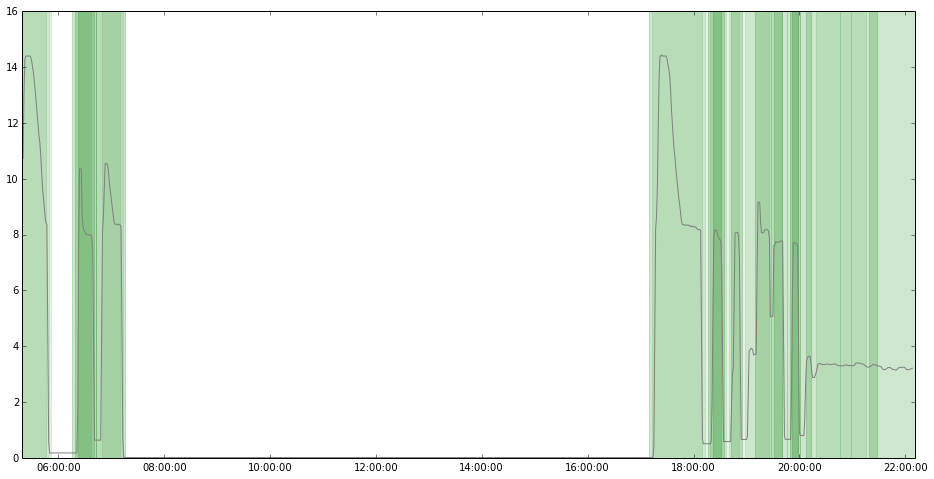

In [24]:
try:
    original_rm, blocks = blockdetection(data)
except MyValidationError as exception:
    # handle exception here and get error message
    print exception

# Pattern recognition using DTW

## Functions

In [26]:
def determine_split_nr(lookup_pattern):
    """
        Find the number of peaks and determin the split number based on this result
        
        PARAMETERS
        ----------
            lookup_pattern: pandas dataframe
            
        RETURNS
        -------
            int
    """
    
    lookup_pattern = pd.DataFrame(data=lookup_pattern)
    lookup_pattern.columns = ['pattern']
    
    cb = lookup_pattern.rolling(window=20).mean()['pattern'].as_matrix()
    ind = argrelextrema(cb, np.greater)
    
    return len(ind) + 1

In [27]:
def split(original, event_list, parts):
    """
        Split the resulting matches in an amount of parts and store their means
        
        PARAMETERS
        ----------
            original: pandas dataframe
            event_list: pandas dataframe
            parts: int
            
        RETURNS
        -------
            pandas dataframe
    """
    
    cols = []
    for i in range(0, parts):
        cols.extend(['part_' + str(i)])    
    parts_df = pd.DataFrame(columns=cols, index=event_list.index)
    
    for i in range(0, event_list.index.size):
        part_length = (pd.Timestamp(event_list['stop'].iloc[i]) - pd.Timestamp(event_list['start'].iloc[i]))/parts
        
        prev_end_time = pd.Timestamp(event_list['start'].iloc[i])
        for j in range(0, parts):
            part_median = original.ix[prev_end_time: prev_end_time + part_length].mean().iloc[0]
            prev_end_time = prev_end_time + part_length
            index = event_list.index[i]
            
            parts_df.set_value(index, 'part_' + str(j), part_median)
            
    split_list = pd.concat([event_list, parts_df],axis=1)
    
    return split_list.sort_values('cost')

In [28]:
def cluster(matches, parts):
    """
        Cluster best matches to label them as beeing a true match or not
        
        PARAMETERS
        ----------
            matches: pandas dataframe
            parts: int
            
        RETURNS
        -------
            pandas dataframe
    """
    
    if matches['cost'].max() == 0:
        max_cost = 1
    else:
        max_cost = matches['cost'].max()
    
    cluster_data = [(matches['cost']/max_cost).as_matrix()]
    for i in range(0, parts):
        cluster_data.extend([(matches['part_' + str(i)]/matches['part_' + str(i)].max()).as_matrix()])
        
    df_result = pd.DataFrame(data=cluster_data).transpose()
    result=df_result.as_matrix()
    
    ms = MeanShift()
    ms.fit(result)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    n_cluster = len(np.unique(labels))
    colors = 10*['g.', 'r.', 'c.', 'b.', 'k.', 'y.', 'm.']
    
    try:
        del split_matches['Type']
    except Exception as e:
        #print 'No column named Type'
        e = e
    
    matches.insert(loc=0, column='Type', value=labels)
    
    return matches

In [29]:
def plot_matches(split_matches, match):
    """
        Function to either plot all matches or plot all non matches
        
        PARAMETERS
        ----------
            split_matches: pandas dataframe
            match: bool
    """
    
    if match:
        for i in range(0, split_matches.index.size):
            if split_matches['Type'].iloc[i] == split_matches['Type'].iloc[0] or split_matches['Type'].iloc[i] == split_matches['Type'].iloc[1]:
                plt.plot(data.ix[pd.Timestamp(split_matches['start'].iloc[i]) - pd.Timedelta(minutes=2):pd.Timestamp(split_matches['stop'].iloc[i]) + pd.Timedelta(minutes=2)])     
    
    else:
        for i in range(0, split_matches.index.size):
            if split_matches['Type'].iloc[i] != split_matches['Type'].iloc[0] and split_matches['Type'].iloc[i] != split_matches['Type'].iloc[1]:
                plt.plot(data.ix[pd.Timestamp(split_matches['start'].iloc[i]) - pd.Timedelta(minutes=2):pd.Timestamp(split_matches['stop'].iloc[i]) + pd.Timedelta(minutes=2)])     
    

In [30]:
def calculate_threshold_value(df_result, nr_of_best_values, factor):
    """
        Determine a broad threshold to filter out all manhattan local minima that are nothing like the desired frame
        
        PARAMETERS
        ----------
            df_result: pandas dataframe
            nr_of_best_values: int
            factor: float
            
        RETURNS
        -------
            pandas dataframe
    """
    
    list_of_best_values=[]
    i = 0
    
    if df_result.index.size > nr_of_best_values:
        for i in range(0, nr_of_best_values):
            list_of_best_values.append(df_result.iloc[i])

        list_of_best_values=pd.DataFrame(list_of_best_values)
        mean=list_of_best_values.mean()
        threshold=mean*factor

        return df_result.loc[df_result['cost']<=threshold[0]]
    
    else:
        return df_result

In [31]:
def DTW_distance(sample_1, sample_2):
    """
        Calculate the similarity between the two samples according to the diferential time warping method
        
        PARAMETERS
        ----------
            sample_1: pandas dataframe
            sample_2: pandas dataframe
            
        RETURNS
        -------
            float
    """
    
    sample_1 = sample_1.as_matrix()
    sample_2 = sample_2.as_matrix()
    
    #compare sample_1 and sample_2 for similarity
    #Get distance
    distances = np.zeros((len(sample_1), len(sample_2)))
    
    for i in range(len(sample_1)):
        for j in range(len(sample_2)):
            #distances[i,j] = (sample_2[j]-sample_1[i])**2
            distances[i,j] = abs(sample_2[j]-sample_1[i]) 


    #get accumulated distance
    accumulated_cost = np.zeros((len(sample_1), len(sample_2)))
    accumulated_cost[0,0] = distances[0,0]
    
    for i in range(0, len(sample_1)):
        for j in range(0, len(sample_2)):
            if i==0 and j==0:
                #i!=0 and j!=0 didn't work..
                i = i
            else:
                if i == 0:
                    accumulated_cost[i, j] = accumulated_cost[i, j-1] + distances[i, j]
                elif j == 0:
                    accumulated_cost[i, j] = accumulated_cost[i-1, j] + distances[i, j]
                else:
                    accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
                    

    path = [[len(sample_2)-1, len(sample_1)-1]]
    cost = 0
    
    i = len(sample_1)-1
    j = len(sample_2)-1
    
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])

    for [y, x] in path:
        cost = cost + distances[x, y]

    #Plot Graphs and dwt distance
    #path_ts_2 = [point[0] for point in path]
    #path_ts_1 = [point[1] for point in path]

    #plt.figure()

    #plt.subplot(121)
    #plt.plot(sample_1)
    #plt.plot(sample_2)

    #plt.subplot(122)
    #distance_cost_plot(accumulated_cost)
    #plt.plot(path_ts_2, path_ts_1);
    #plt.show()

    return cost

In [32]:
def check_if_child(blocks, sample_1_id, sample_2_id):
    parent_1 = sample_1_id
    parent_2 = sample_2_id
    
    do_check = False
    
    found = False
    while not found:
        #If they are 
        if parent_1 != -1 and parent_1 != sample_2_id:
            parent_1 = blocks['nested_in'].loc[parent_1]
            
        elif parent_1 == sample_2_id:
            do_check = False
            found = True
        
        elif parent_1 == -1:
            do_check = True
            found = True
    
    if do_check:
        found = False
        while not found:
            #If they are 
            if parent_2 != -1 and parent_2 != sample_1_id:
                parent_2 = blocks['nested_in'].loc[parent_2]

            elif parent_2 == sample_1_id:
                do_check = False
                found = True

            elif parent_2 == -1:
                do_check = True
                found = True
        
    return do_check

In [33]:
def check_overlap(search_pattern, found_patterns):
    """
        Check if the lookup pattern has already been found
        
        PARAMETERS
        ----------
            sample_1: pandas dataframe
            sample_2: pandas dataframe
            
        RETURNS
        -------
            Boolean
    """
    
    search_start = search_pattern.index[0]
    search_stop = search_pattern.index[-1]
    
    for i in range(0, found_patterns.index.size):
        found_start = pd.Timestamp(found_patterns['start'].iloc[i])
        found_stop = pd.Timestamp(found_patterns['stop'].iloc[i])
        
        if search_start > found_start and search_start < found_stop and search_stop > found_stop:
            overlap = 1 - ((search_start - found_start)/(found_stop - found_start))
            if overlap > 0.5:
                return False
        
        elif search_stop > found_start and search_stop < found_stop and search_start < found_start:
            overlap = ((search_stop - found_start)/(found_stop - found_start))
            if overlap > 0.5:
                return False
        
        elif search_start > found_start and search_start < found_stop and search_stop > found_start and search_stop < found_stop:
            return False
        
        elif search_start < found_start and search_start > found_stop and search_stop < found_start and search_stop > found_stop:
            return False
        
    return True

In [34]:
try:
    del blocks['Type']
except Exception as e:
    print 'No column named Type'

zeros = np.zeros(blocks.index.size)
blocks.insert(loc=0, column='Type', value=zeros)

types = pd.DataFrame(columns=['start', 'stop', 'Type'])

event_type = 1
for i in range(0, blocks.index.size):
    sys.stdout.write("\r" + str(i) + '/' + str(blocks.index.size))
    
    dtw_cost = pd.DataFrame(columns=['start', 'stop', 'cost'])
    
    #If the event has not been recognized yet check with other events
    if blocks['Type'].iloc[i] == 0:
    
        search_pattern = pd.DataFrame(data=original_rm).ix[pd.Timestamp(blocks['start'].iloc[i]) - pd.Timedelta(minutes=2):pd.Timestamp(blocks['stop'].iloc[i]) + pd.Timedelta(minutes=2)]    
        temp = pd.DataFrame(data=[[blocks['start'].iloc[i], blocks['stop'].iloc[i], 0]], index=[blocks.index[i]], columns=['start', 'stop', 'cost'])
        dtw_cost = dtw_cost.append(temp)
        
        for j in range(i, blocks.index.size):
            
            if blocks['nested_in'].iloc[j] == -1:
                compare_pattern = pd.DataFrame(data=original_rm).ix[pd.Timestamp(blocks['start'].iloc[j]) - pd.Timedelta(minutes=2):pd.Timestamp(blocks['stop'].iloc[j]) + pd.Timedelta(minutes=2)]    

                #Check if the length is more or less the same
                if search_pattern.size < compare_pattern.size * 1.25 and search_pattern.size > compare_pattern.size * 0.75:
                    #Check if the blocks are nested in each other
                    if check_if_child(blocks, blocks.index[i], blocks.index[j]):
                        #Check if the pattern has already been found
                        if (check_overlap(search_pattern, types)):

                            #Manthattan
                            if (search_pattern.size < compare_pattern.size):
                                res = loop_through_list(compare_pattern, search_pattern)
                            else:
                                res = loop_through_list(search_pattern, compare_pattern)

                            if len(res) > 0:
                                temp = pd.DataFrame(data=res, columns=['cost', 'start', 'stop']).iloc[0]

                                #store all costs and id's
                                #temp = pd.DataFrame(data=[[blocks['start'].iloc[j], blocks['stop'].iloc[j], cost]], index=[blocks.index[j]], columns=['start', 'stop', 'cost'])
                                dtw_cost = dtw_cost.append(temp)
        
        if dtw_cost.index.size > 3:
            
            dtw_cost = calculate_threshold_value(dtw_cost, 20, 2)
        
            split_number = determine_split_nr(search_pattern)
            split_matches = split(original_rm, dtw_cost, split_number)
        
            split_matches = cluster(split_matches, split_number)
        
            #all events labled the same as row 0 or 1 are a match
            lable_1 = split_matches['Type'].iloc[0] 
            lable_2 = split_matches['Type'].iloc[1]
        
            for j in range(0, split_matches.index.size):
                if split_matches['Type'].iloc[j] == lable_1 or split_matches['Type'].iloc[j] == lable_2:
                    types = types.append(pd.DataFrame(data=[[split_matches['start'].iloc[j], split_matches['stop'].iloc[j], event_type]], columns=['start', 'stop', 'Type']))
        
            event_type = event_type + 1
        
        del dtw_cost

No column named Type
41/42

In [35]:
types

,start,stop,Type


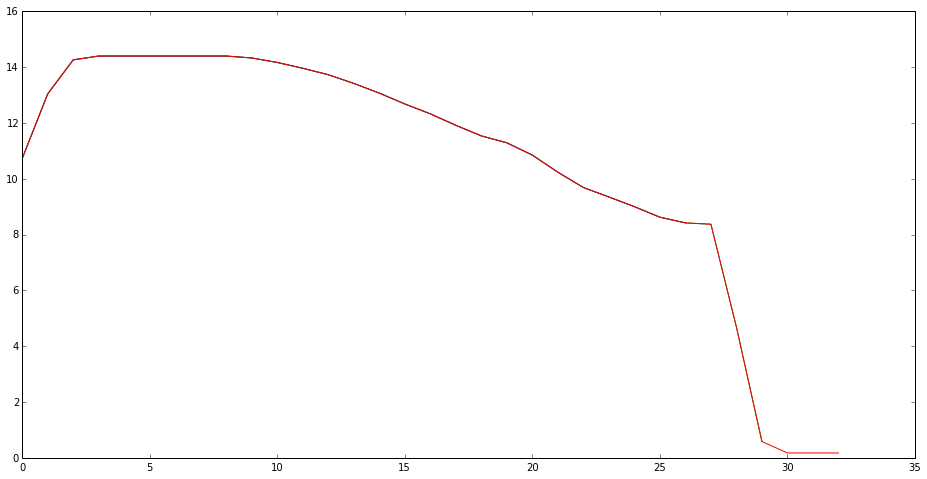

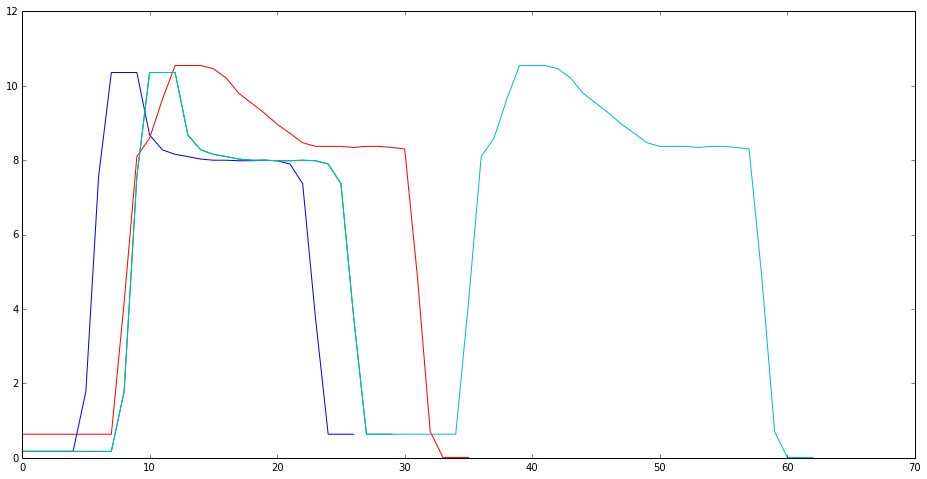

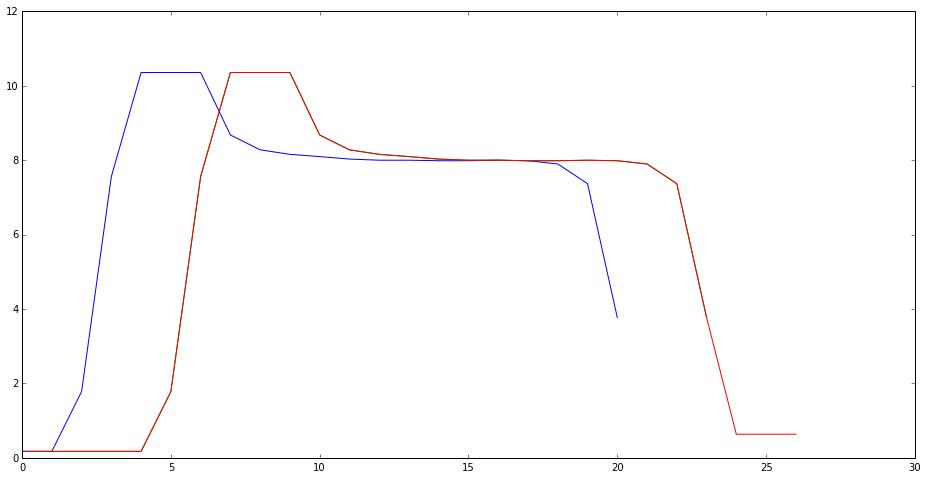

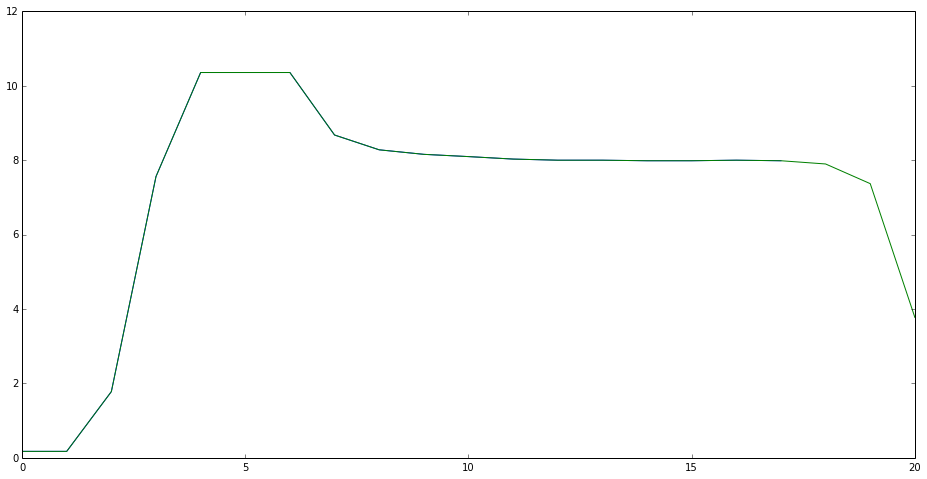

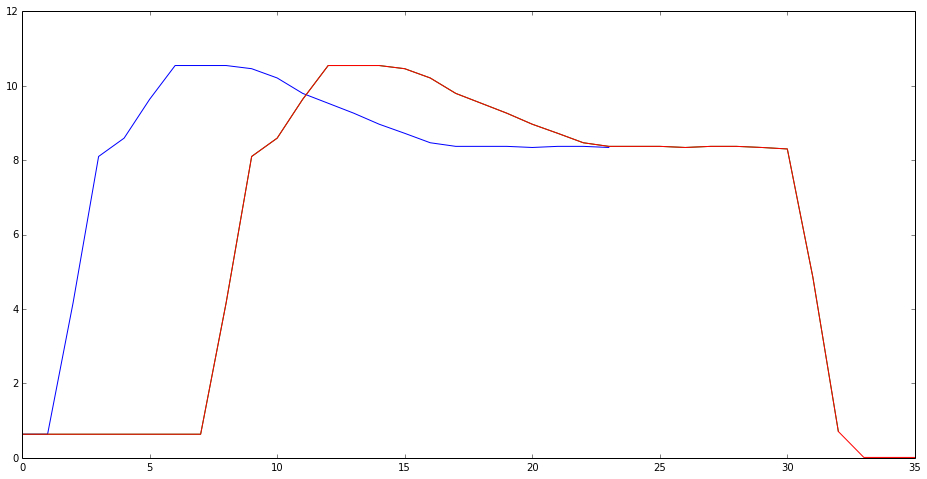

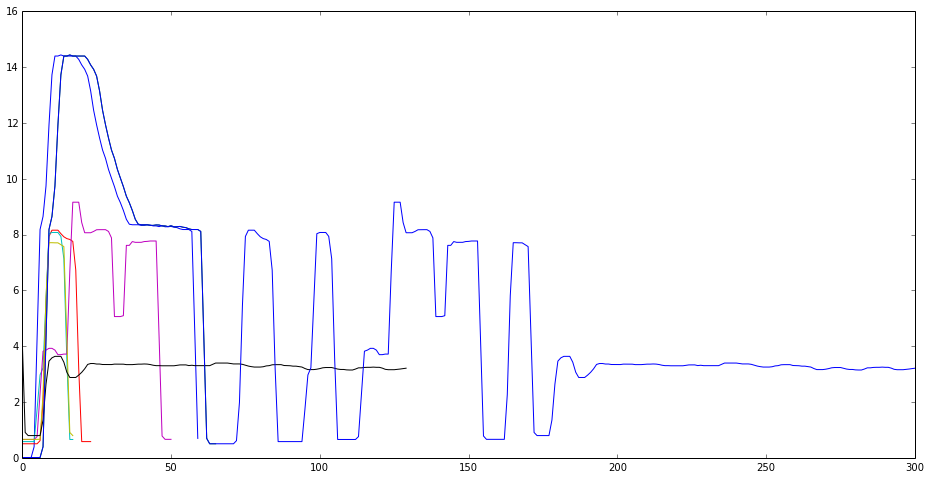

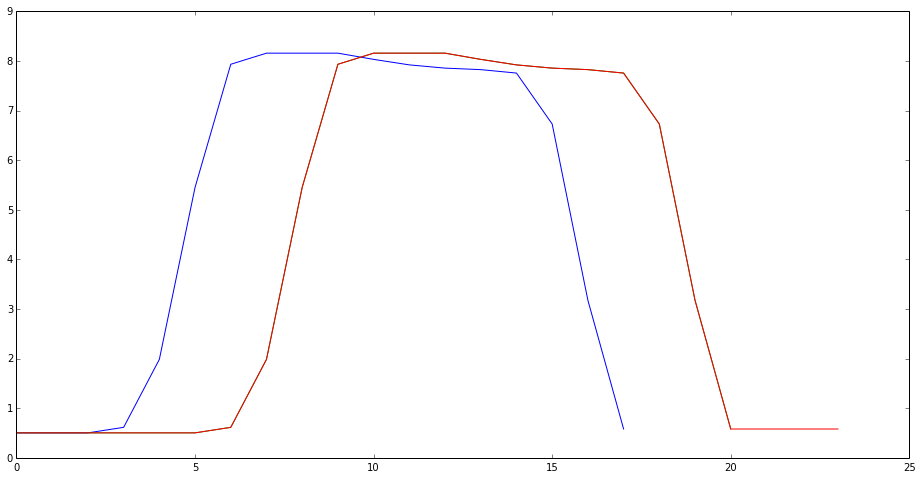

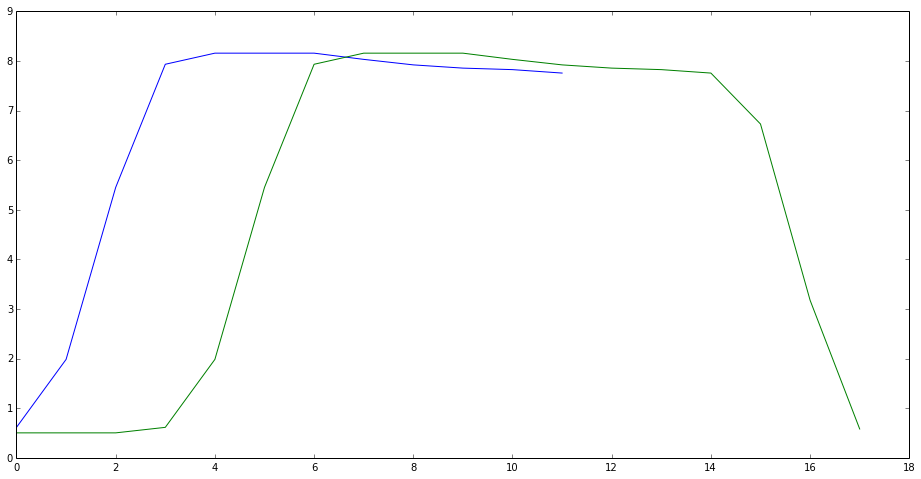

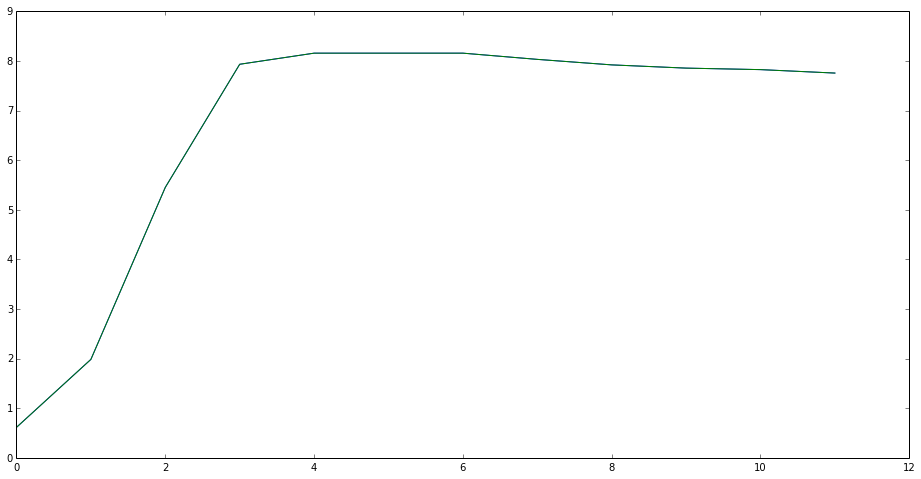

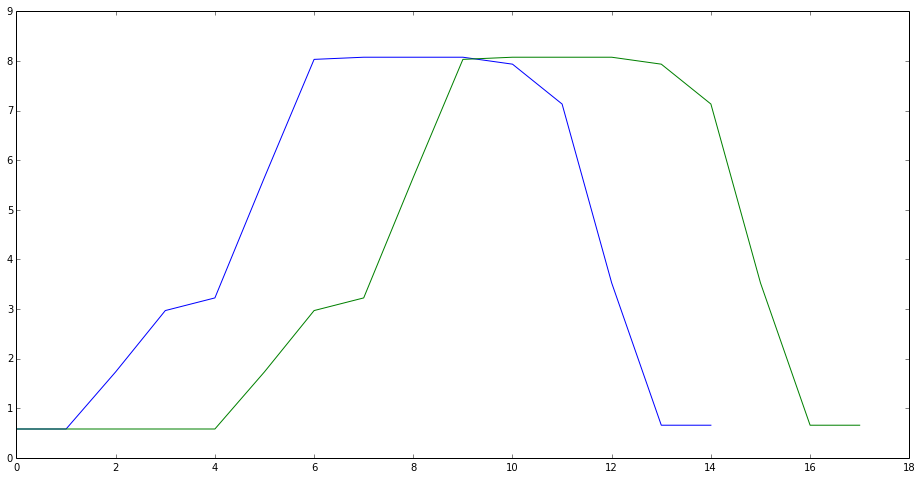

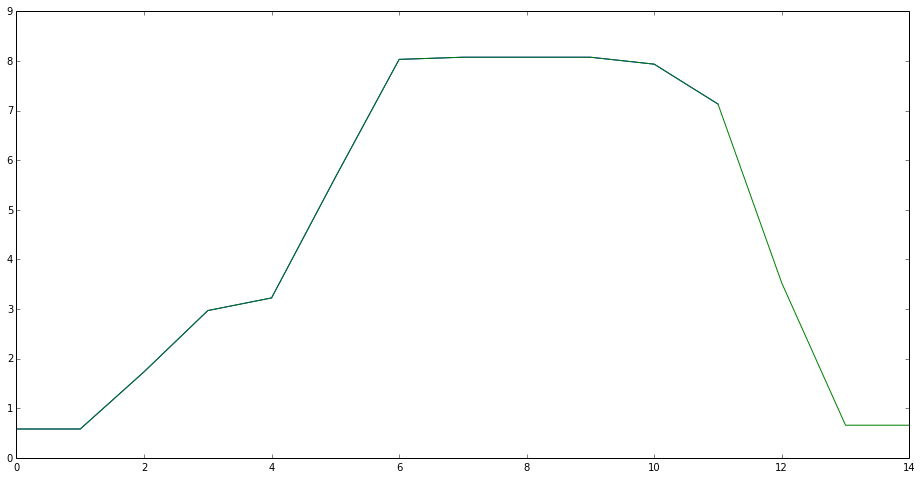

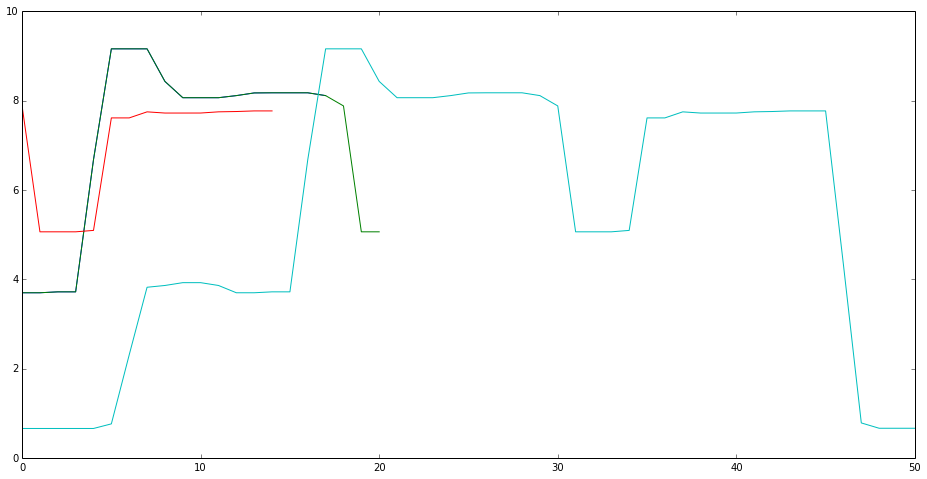

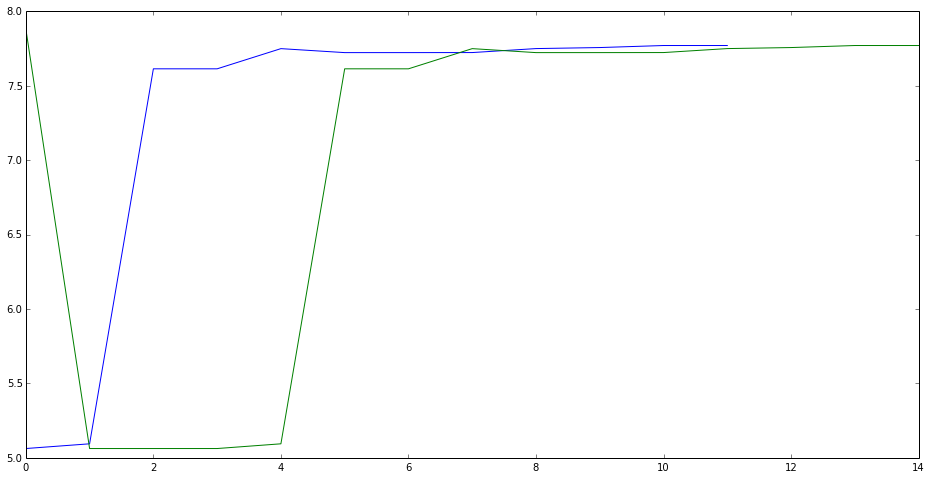

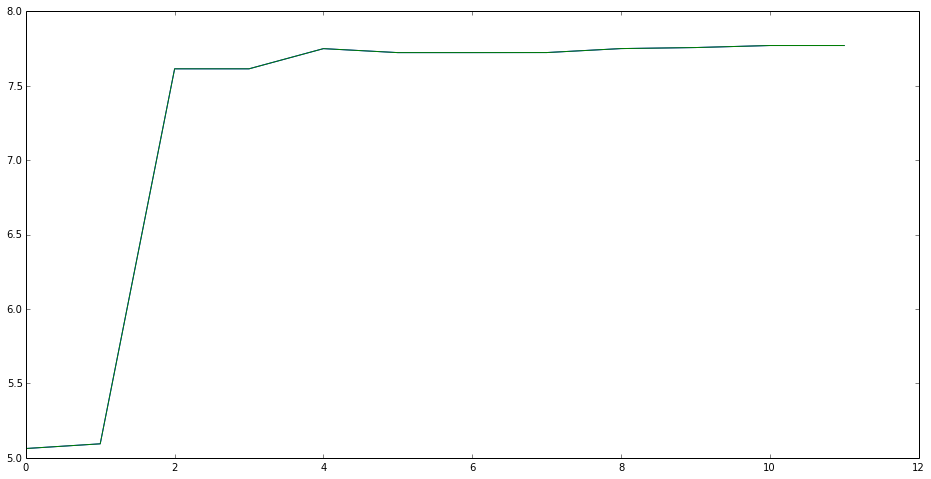

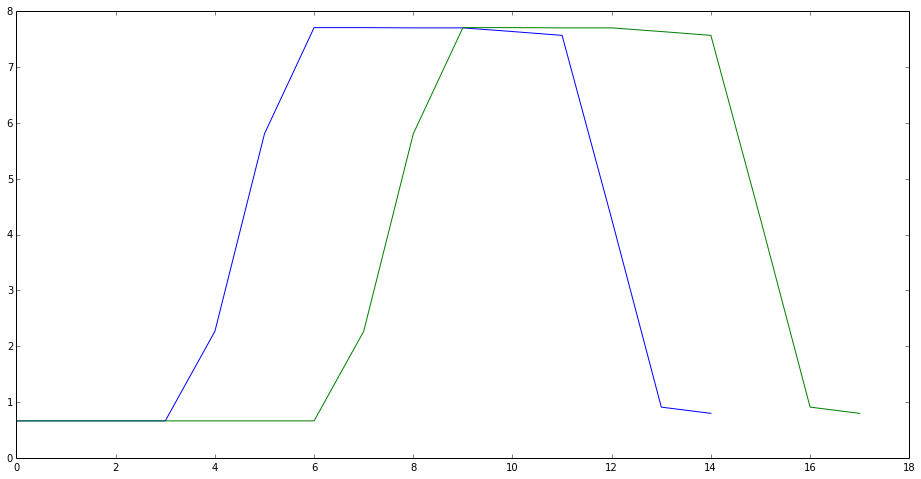

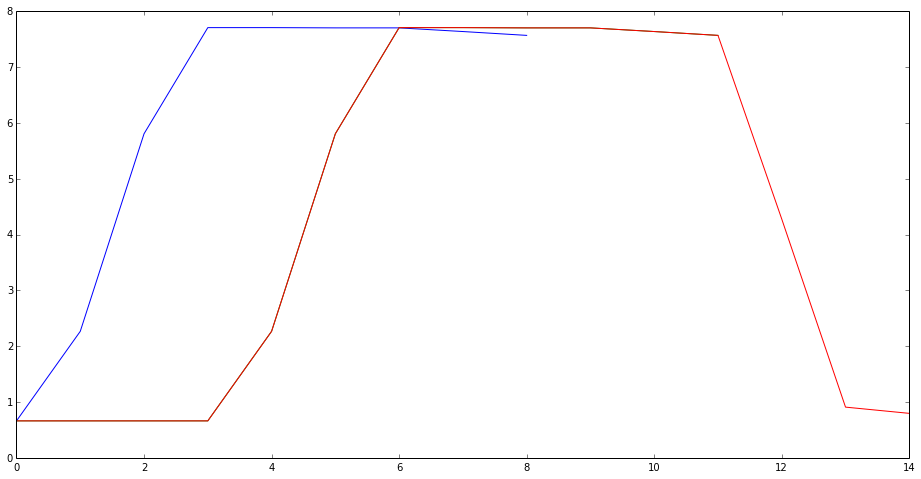

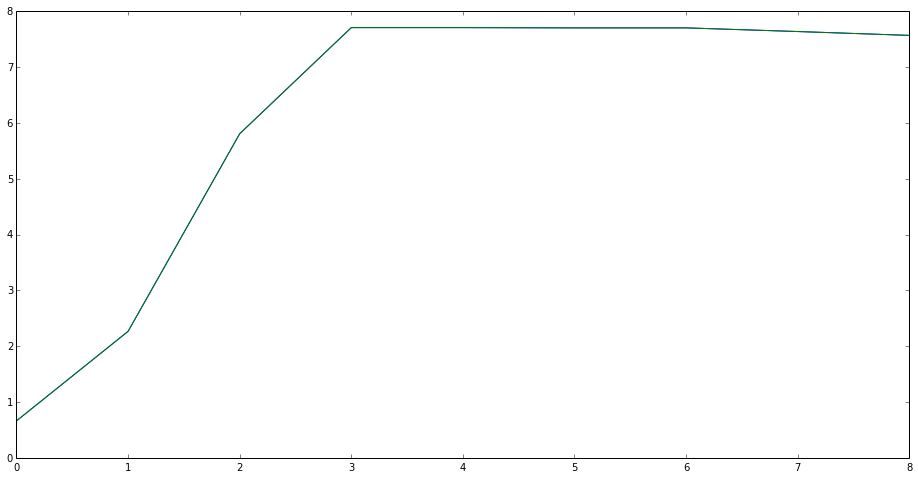

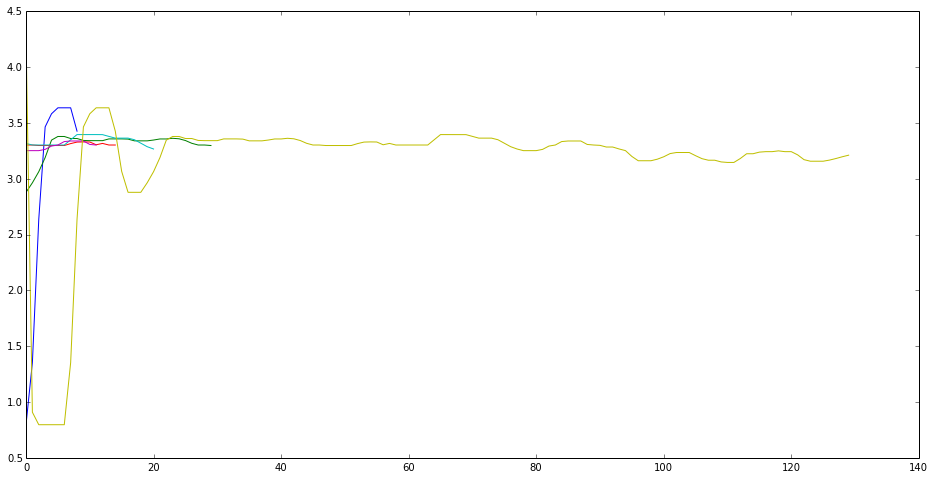

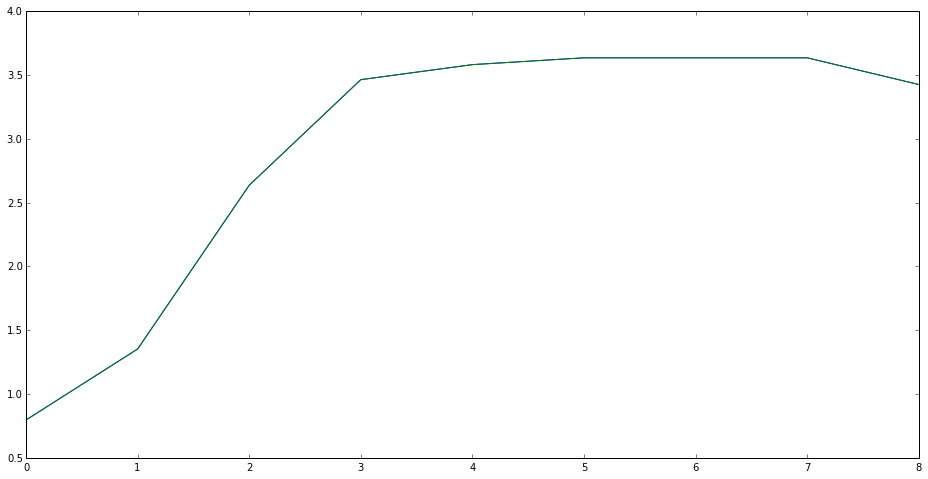

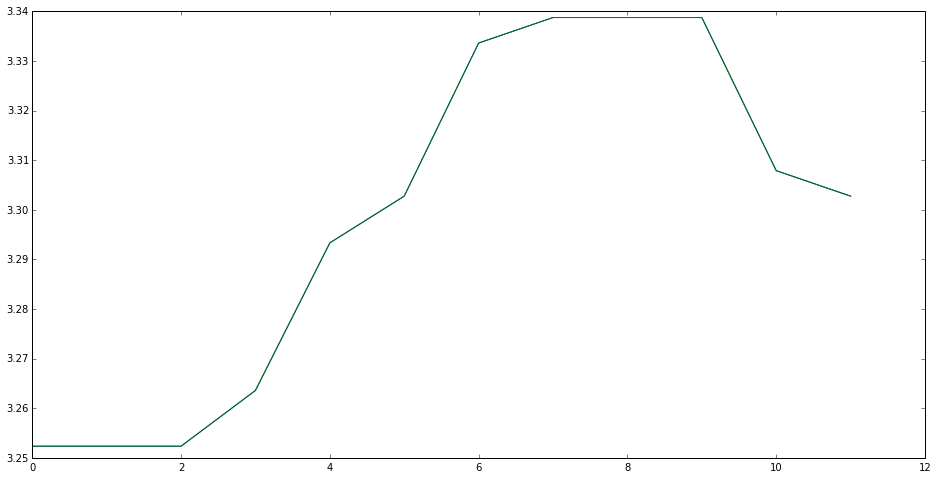

In [36]:
for j in range(0, 100):
    plt.figure(j)
    count = 0
    for i in range(0, blocks.index.size):
        if blocks['nested_in'].iloc[i] == j:
            plt.plot(original_rm.ix[pd.Timestamp(blocks['start'].iloc[i]) - pd.Timedelta(minutes=2):pd.Timestamp(blocks['stop'].iloc[i]) + pd.Timedelta(minutes=2)])
            count = count + 1
    
    if(count > 0):
        plt.plot(original_rm.ix[pd.Timestamp(blocks['start'].loc[j]) - pd.Timedelta(minutes=2):pd.Timestamp(blocks['stop'].loc[j]) + pd.Timedelta(minutes=2)])
            
    
    plt.show()

In [37]:
blocks

,Type,start,stop,nested_in
0,0.0,2015-11-17 05:19:00+00:00,2015-11-17 05:50:00+00:00,-1.0
1,0.0,2015-11-17 05:19:00+00:00,2015-11-17 05:44:00+00:00,0.0
2,0.0,2015-11-17 05:19:00+00:00,2015-11-17 05:47:00+00:00,0.0
3,0.0,2015-11-17 06:16:00+00:00,2015-11-17 07:14:00+00:00,-1.0
4,0.0,2015-11-17 06:19:00+00:00,2015-11-17 06:41:00+00:00,3.0
5,0.0,2015-11-17 06:22:00+00:00,2015-11-17 06:38:00+00:00,4.0
6,0.0,2015-11-17 06:22:00+00:00,2015-11-17 06:35:00+00:00,5.0
7,0.0,2015-11-17 06:19:00+00:00,2015-11-17 06:38:00+00:00,4.0
8,0.0,2015-11-17 06:16:00+00:00,2015-11-17 06:41:00+00:00,3.0
9,0.0,2015-11-17 06:43:00+00:00,2015-11-17 07:14:00+00:00,3.0


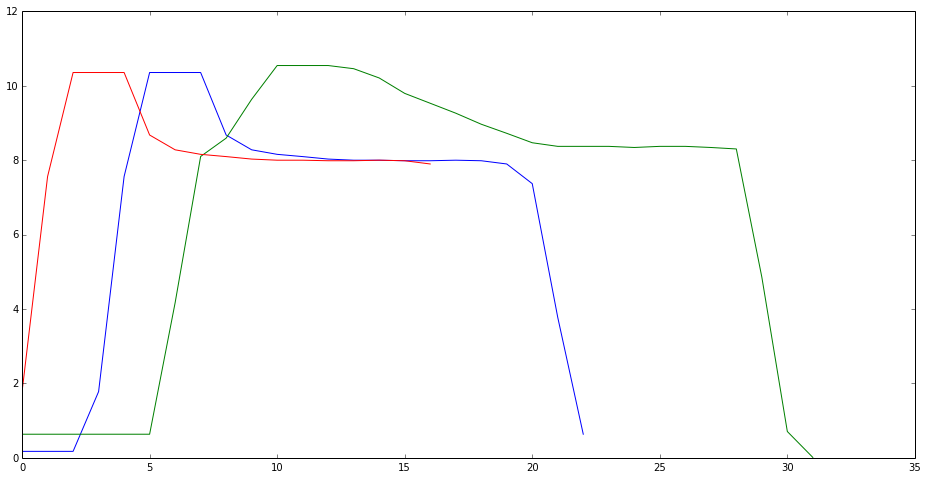

In [38]:
i = 4
plt.plot(original_rm.ix[pd.Timestamp(blocks['start'].iloc[i]) :pd.Timestamp(blocks['stop'].iloc[i])])
i = 9
plt.plot(original_rm.ix[pd.Timestamp(blocks['start'].iloc[i]) :pd.Timestamp(blocks['stop'].iloc[i])])
i = 5
plt.plot(original_rm.ix[pd.Timestamp(blocks['start'].iloc[i]) :pd.Timestamp(blocks['stop'].iloc[i])])
plt.show() 